# Calibrate all porpoise tracks

In [1]:
from pathlib import Path
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from pp_utils.video_projection import video_projection

## Initialize a `video_projection` object

In [3]:
projection_path = Path('../pp_utils/point_projections/data')

In [4]:
intrisinc_path = str(projection_path.joinpath('intrinsic_calibration'))
extrinsic_path = str(projection_path.joinpath('extrinsic_calibration'))

vp = video_projection(intrisinc_path=intrisinc_path, extrinsic_path=extrinsic_path)

## Load cal object info

In [5]:
cal_obj_file = projection_path / 'list_calibration_clips.xlsx'
df_cal = pd.read_excel(cal_obj_file)

In [6]:
df_cal

,DATE,SESSION,VIDEO,FRAME_START,FRAME_END,CAL_OBJECT,CAL_VIDEO_PATH,CAL_VIDEO_FILENAME,HULA_HOOP_FLIPPED,HULA_HOOP_POINTS,FRAME_MARKED,FRAME_EXTRACTED,SIDEDNESS_CHECKED,COMMENTS
0,20190625,1,GP011466,9356,10533,hula,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190625_s1_GP011466_9356_10533_hula.mp4,Y,"1,4,6,8,10",432,Y,Y,NaN
1,20190625,2,GP011467,4053,4752,hula,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190625_s2_GP011467_4053_4752_hula.mp4,Y,"1,4,6,8,10",325,Y,Y,NaN
2,20190625,3,--,--,--,--,--,--,--,--,--,--,--,NaN
3,20190626,1,GOPR1469,30132,30959,hula,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190626_s1_GOPR1469_30132_30959_hula.mp4,Y,"1,4,6,8,10",436,Y,Y,NaN
4,20190626,2,GP011470,12382,13135,hula,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190626_s2_GP011470_12382_13135_hula.mp4,N,"1,4,6,8,10",376,Y,Y,NaN
5,20190626,3,GP011471,15043,15616,hula,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190626_s3_GP011471_15043_15616_hula.mp4,Y,"1,4,6,8,10",304,Y,Y,NaN
6,20190627,1,GP011472,9936,10594,hula,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190627_s1_GP011472_9936_10594_hula.mp4,Y,"1,4,6,8,10",344,Y,Y,NaN
7,20190627,2,GP011473,24941,25606,hula,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190627_s2_GP011473_24941_25606_hula.mp4,Y,"1,2,4,6,8,10",292,Y,Y,NaN
8,20190627,3,GP011474,14227,14755,hula,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190627_s3_GP011474_14227_14755_hula.mp4,Y,"1,2,4,6,8,10",285,Y,Y,NaN
9,20190628,1,GP011475,10745,11214,hula,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190628_s1_GP011475_10745_11214_hula.mp4,Y,"1,2,4,6,8,10",213,Y,Y,NaN


## Set paths for xypressure data and outputs

In [7]:
analysis_path = Path('../data_processed/')

In [8]:
xyz_path = analysis_path.joinpath('tracks/xypressure/csv/')

output_path = analysis_path.joinpath('tracks/xypressure_cal/')
if not output_path.exists():
    output_path.mkdir()

In [9]:
FILENAME_MATCHER = re.compile('(?P<date>\d{8})_s(?P<session>\d{1})'
                              +'_t(?P<trial>\d{1,2})_(?P<video>\w{8})_xypressure.csv')

## Load the updated main data frame

In [10]:
df_main = pd.read_csv(analysis_path.joinpath('all_info_csv/main_info_append_04.csv'), index_col=0)

## Get label names in xyz files

In [11]:
xyz_files = sorted(list(xyz_path.glob('*.csv')))

In [12]:
df_xyz = pd.read_csv(xyz_files[0])

In [13]:
# Get label names: we know there are 5 points to track
pt_track = 5
label_names = [x[:-2] for x in df_xyz.columns[::2][:pt_track].values]
label_names

['LEFT_EYE', 'RIGHT_EYE', 'NOSTRIL', 'BACK', 'DTAG']

## Loop through all xyz files

Note in below `cal_obj_record_exist` and `extrinsic_file_exist` are for sanity check only. These two columns have already been appended in `20210122_02_calibrate-target-locs.ipynb`.

In [14]:
def cal_and_save():
    extrinsics = vp.get_extrinsic_vals(extrinsic_file)
    df_xyz = pd.read_csv(track_file)
    
    # project track points
    df_xyz_new = vp.proc_xyz_track(extrinsics, df_xyz, label_names)

    # save calibrated target locations
    fname = '%s_%s.csv' % (Path(track_file).stem, cal_obj)
    print('save new file: %s' % fname)
    df_xyz_new.to_csv(output_path.joinpath(fname))
    return df_xyz_new

In [15]:
# lists to store reasons for skipping a file
track_file_exist = []
cal_obj_record_exist = []
extrinsic_file_exist = []

for idx_main in df_main.index:
    
    s_main = df_main.loc[idx_main, :]
    fname_prefix = '%d_s%d_t%d' % (s_main['DATE'], s_main['SESSION'], s_main['TRIAL'])

    print('---------------------------------------------------')
    print(fname_prefix)

    # find corresponding track xypressure file
    track_file = list(Path(xyz_path).glob(fname_prefix+'*.csv'))
    if not track_file:  # if list empty: not track file
        track_file_exist.append(False)
        cal_obj_record_exist.append('NaN')
        extrinsic_file_exist.append('NaN')
        print('no corresponding track file entry found, skipping file...')
        continue
    else:
        track_file_exist.append(True)
        track_file = str(track_file[0])  # should only have 1 corresponding file
        
        # get cal info
        sel_row = df_cal.loc[(df_cal['DATE']==s_main['DATE']) 
                             & (df_cal['SESSION']==s_main['SESSION']), :]
        extrinsic_cal_prefix = '%s_s%s_' % (s_main['DATE'], s_main['SESSION'])

        # SOME TRIALS HAVE CROSS CAL
        if len(sel_row) == 2:  # sessions with both cross and hula cal obj
            cal_obj = 'cross'
            extrinsic_file = vp.get_extrinsic_filename(extrinsic_cal_prefix, cal_obj)
            extrinsics = vp.get_extrinsic_vals(extrinsic_file)
            if extrinsic_file:  # if extrinsic file exists
                df_xyz_new = cal_and_save()
            else:
                continue

        # ALL TRIALS HAVE HULA CAL
        flip = sel_row.loc[sel_row['CAL_OBJECT'] == 'hula', 'HULA_HOOP_FLIPPED'].values
        if flip.size > 0:  # if Y/N exists
            cal_obj_record_exist.append(True)
            if flip == 'Y':
                cal_obj = 'hula_flip'
            else:
                cal_obj = 'hula_noflip'
            extrinsic_file = vp.get_extrinsic_filename(extrinsic_cal_prefix, cal_obj)
            if extrinsic_file:  # if extrinsic file exists
                extrinsic_file_exist.append(True)
                df_xyz_new = cal_and_save()
            else:
                extrinsic_file_exist.append(False)
                print('no extrinsic file, skipping file...')
                continue
        else:
            cal_obj_record_exist.append(False)
            extrinsic_file_exist.append('NaN')
            print('no record for cal object, skipping file...')
            continue

---------------------------------------------------
20190625_s1_t0
no corresponding track file entry found, skipping file...
---------------------------------------------------
20190625_s1_t0
no corresponding track file entry found, skipping file...
---------------------------------------------------
20190625_s1_t1
save new file: 20190625_s1_t1_GOPR1466_xypressure_hula_flip.csv
---------------------------------------------------
20190625_s1_t2
save new file: 20190625_s1_t2_GOPR1466_xypressure_hula_flip.csv
---------------------------------------------------
20190625_s1_t3
save new file: 20190625_s1_t3_GOPR1466_xypressure_hula_flip.csv
---------------------------------------------------
20190625_s1_t4
save new file: 20190625_s1_t4_GOPR1466_xypressure_hula_flip.csv
---------------------------------------------------
20190625_s1_t5
save new file: 20190625_s1_t5_GOPR1466_xypressure_hula_flip.csv
---------------------------------------------------
20190625_s1_t6
save new file: 20190625_s1_t

---------------------------------------------------
20190626_s2_t8
save new file: 20190626_s2_t8_GP011470_xypressure_hula_noflip.csv
---------------------------------------------------
20190626_s2_t9
save new file: 20190626_s2_t9_GP011470_xypressure_hula_noflip.csv
---------------------------------------------------
20190626_s2_t10
save new file: 20190626_s2_t10_GP011470_xypressure_hula_noflip.csv
---------------------------------------------------
20190626_s3_t1
save new file: 20190626_s3_t1_GOPR1471_xypressure_hula_flip.csv
---------------------------------------------------
20190626_s3_t2
save new file: 20190626_s3_t2_GOPR1471_xypressure_hula_flip.csv
---------------------------------------------------
20190626_s3_t3
save new file: 20190626_s3_t3_GP011471_xypressure_hula_flip.csv
---------------------------------------------------
20190626_s3_t4
save new file: 20190626_s3_t4_GP011471_xypressure_hula_flip.csv
---------------------------------------------------
20190626_s3_t5
save new

---------------------------------------------------
20190627_s3_t4
save new file: 20190627_s3_t4_GOPR1474_xypressure_hula_flip.csv
---------------------------------------------------
20190627_s3_t5
save new file: 20190627_s3_t5_GOPR1474_xypressure_hula_flip.csv
---------------------------------------------------
20190627_s3_t6
save new file: 20190627_s3_t6_GOPR1474_xypressure_hula_flip.csv
---------------------------------------------------
20190627_s3_t7
save new file: 20190627_s3_t7_GP011474_xypressure_hula_flip.csv
---------------------------------------------------
20190627_s3_t8
save new file: 20190627_s3_t8_GP011474_xypressure_hula_flip.csv
---------------------------------------------------
20190627_s3_t9
save new file: 20190627_s3_t9_GP011474_xypressure_hula_flip.csv
---------------------------------------------------
20190627_s3_t10
save new file: 20190627_s3_t10_GP011474_xypressure_hula_flip.csv
---------------------------------------------------
20190627_s3_t11
save new file

---------------------------------------------------
20190628_s3_t2
save new file: 20190628_s3_t2_GOPR1477_xypressure_hula_noflip.csv
---------------------------------------------------
20190628_s3_t3
save new file: 20190628_s3_t3_GOPR1477_xypressure_hula_noflip.csv
---------------------------------------------------
20190628_s3_t4
save new file: 20190628_s3_t4_GOPR1477_xypressure_hula_noflip.csv
---------------------------------------------------
20190628_s3_t5
save new file: 20190628_s3_t5_GOPR1477_xypressure_hula_noflip.csv
---------------------------------------------------
20190628_s3_t6
save new file: 20190628_s3_t6_GOPR1477_xypressure_hula_noflip.csv
---------------------------------------------------
20190628_s3_t7
save new file: 20190628_s3_t7_GOPR1477_xypressure_hula_noflip.csv
---------------------------------------------------
20190628_s3_t8
save new file: 20190628_s3_t8_GOPR1477_xypressure_hula_noflip.csv
---------------------------------------------------
20190628_s3_t9
sa

no record for cal object, skipping file...
---------------------------------------------------
20190701_s3_t2
no record for cal object, skipping file...
---------------------------------------------------
20190701_s3_t3
no record for cal object, skipping file...
---------------------------------------------------
20190701_s3_t4
no record for cal object, skipping file...
---------------------------------------------------
20190701_s3_t5
no record for cal object, skipping file...
---------------------------------------------------
20190701_s3_t6
no corresponding track file entry found, skipping file...
---------------------------------------------------
20190701_s3_t7
no record for cal object, skipping file...
---------------------------------------------------
20190701_s3_t8
no record for cal object, skipping file...
---------------------------------------------------
20190701_s3_t9
no record for cal object, skipping file...
---------------------------------------------------
20190701_s

save new file: 20190702_s3_t5_GOPR1483_xypressure_hula_noflip.csv
---------------------------------------------------
20190702_s3_t6
save new file: 20190702_s3_t6_GOPR1483_xypressure_cross.csv
save new file: 20190702_s3_t6_GOPR1483_xypressure_hula_noflip.csv
---------------------------------------------------
20190702_s3_t7
save new file: 20190702_s3_t7_GOPR1483_xypressure_cross.csv
save new file: 20190702_s3_t7_GOPR1483_xypressure_hula_noflip.csv
---------------------------------------------------
20190702_s3_t8
save new file: 20190702_s3_t8_GOPR1483_xypressure_cross.csv
save new file: 20190702_s3_t8_GOPR1483_xypressure_hula_noflip.csv
---------------------------------------------------
20190702_s3_t9
save new file: 20190702_s3_t9_GOPR1483_xypressure_cross.csv
save new file: 20190702_s3_t9_GOPR1483_xypressure_hula_noflip.csv
---------------------------------------------------
20190702_s3_t10
save new file: 20190702_s3_t10_GP011483_xypressure_cross.csv
save new file: 20190702_s3_t10_GP

save new file: 20190703_s1_t10_GOPR1484_xypressure_hula_noflip.csv
---------------------------------------------------
20190703_s2_t1
save new file: 20190703_s2_t1_GOPR1485_xypressure_cross.csv
save new file: 20190703_s2_t1_GOPR1485_xypressure_hula_noflip.csv
---------------------------------------------------
20190703_s2_t2
save new file: 20190703_s2_t2_GOPR1485_xypressure_cross.csv
save new file: 20190703_s2_t2_GOPR1485_xypressure_hula_noflip.csv
---------------------------------------------------
20190703_s2_t3
save new file: 20190703_s2_t3_GOPR1485_xypressure_cross.csv
save new file: 20190703_s2_t3_GOPR1485_xypressure_hula_noflip.csv
---------------------------------------------------
20190703_s2_t4
save new file: 20190703_s2_t4_GOPR1485_xypressure_cross.csv
save new file: 20190703_s2_t4_GOPR1485_xypressure_hula_noflip.csv
---------------------------------------------------
20190703_s2_t5
save new file: 20190703_s2_t5_GOPR1485_xypressure_cross.csv
save new file: 20190703_s2_t5_GOPR

save new file: 20190703_s3_t6_GOPR1486_xypressure_hula_noflip.csv
---------------------------------------------------
20190703_s3_t7
save new file: 20190703_s3_t7_GOPR1486_xypressure_cross.csv
save new file: 20190703_s3_t7_GOPR1486_xypressure_hula_noflip.csv
---------------------------------------------------
20190703_s3_t8
save new file: 20190703_s3_t8_GOPR1486_xypressure_cross.csv
save new file: 20190703_s3_t8_GOPR1486_xypressure_hula_noflip.csv
---------------------------------------------------
20190703_s3_t9
save new file: 20190703_s3_t9_GOPR1486_xypressure_cross.csv
save new file: 20190703_s3_t9_GOPR1486_xypressure_hula_noflip.csv
---------------------------------------------------
20190703_s3_t10
save new file: 20190703_s3_t10_GOPR1486_xypressure_cross.csv
save new file: 20190703_s3_t10_GOPR1486_xypressure_hula_noflip.csv
---------------------------------------------------
20190704_s1_t1
save new file: 20190704_s1_t1_GOPR1487_xypressure_cross.csv
save new file: 20190704_s1_t1_GO

save new file: 20190704_s2_t1_GOPR1488_xypressure_hula_noflip.csv
---------------------------------------------------
20190704_s2_t2
save new file: 20190704_s2_t2_GOPR1488_xypressure_cross.csv
save new file: 20190704_s2_t2_GOPR1488_xypressure_hula_noflip.csv
---------------------------------------------------
20190704_s2_t3
save new file: 20190704_s2_t3_GOPR1488_xypressure_cross.csv
save new file: 20190704_s2_t3_GOPR1488_xypressure_hula_noflip.csv
---------------------------------------------------
20190704_s2_t4
save new file: 20190704_s2_t4_GOPR1488_xypressure_cross.csv
save new file: 20190704_s2_t4_GOPR1488_xypressure_hula_noflip.csv
---------------------------------------------------
20190704_s2_t5
save new file: 20190704_s2_t5_GOPR1488_xypressure_cross.csv
save new file: 20190704_s2_t5_GOPR1488_xypressure_hula_noflip.csv
---------------------------------------------------
20190704_s2_t6
save new file: 20190704_s2_t6_GOPR1488_xypressure_cross.csv
save new file: 20190704_s2_t6_GOPR1

save new file: 20190704_s3_t4_GOPR1489_xypressure_hula_flip.csv
---------------------------------------------------
20190704_s3_t5
save new file: 20190704_s3_t5_GOPR1489_xypressure_cross.csv
save new file: 20190704_s3_t5_GOPR1489_xypressure_hula_flip.csv
---------------------------------------------------
20190704_s3_t6
save new file: 20190704_s3_t6_GOPR1489_xypressure_cross.csv
save new file: 20190704_s3_t6_GOPR1489_xypressure_hula_flip.csv
---------------------------------------------------
20190704_s3_t7
save new file: 20190704_s3_t7_GOPR1489_xypressure_cross.csv
save new file: 20190704_s3_t7_GOPR1489_xypressure_hula_flip.csv
---------------------------------------------------
20190704_s3_t8
save new file: 20190704_s3_t8_GOPR1489_xypressure_cross.csv
save new file: 20190704_s3_t8_GOPR1489_xypressure_hula_flip.csv
---------------------------------------------------
20190704_s3_t9
save new file: 20190704_s3_t9_GOPR1489_xypressure_cross.csv
save new file: 20190704_s3_t9_GOPR1489_xypres

In [16]:
# Sanity check of dimension
len(extrinsic_file_exist), len(cal_obj_record_exist), len(track_file_exist)

(247, 247, 247)

In [17]:
len(df_main)

247

## Append new info column to main dataframe

In [18]:
df_main['xypressure_file_exist'] = track_file_exist

In [19]:
df_main.to_csv(analysis_path.joinpath('all_info_csv/main_info_append_05.csv'))

## Explore calibrated results

In [20]:
sel_row

,DATE,SESSION,VIDEO,FRAME_START,FRAME_END,CAL_OBJECT,CAL_VIDEO_PATH,CAL_VIDEO_FILENAME,HULA_HOOP_FLIPPED,HULA_HOOP_POINTS,FRAME_MARKED,FRAME_EXTRACTED,SIDEDNESS_CHECKED,COMMENTS
31,20190704,3,GP011489,3480,4283,hula,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190704_s3_GP011489_3480_4283_hula.mp4,Y,all,401,Y,Y,NaN
32,20190704,3,GP011489,4822,5236,cross,/Volumes/MURI_4TB/clutter_infotaxis_analysis/v...,20190704_s3_GP011489_4822_5236_cross.mp4,NaN,NaN,1,NaN,NaN,NaN


In [21]:
df_xyz_new.to_csv()

',LEFT_EYE_X,LEFT_EYE_Y,RIGHT_EYE_X,RIGHT_EYE_Y,ROSTRUM_X,ROSTRUM_Y,BACK_X,BACK_Y,DTAG_X,DTAG_Y,DTAG_PRESSURE\n0,,,,,,,,,,,-0.4820541962364571\n1,,,,,,,,,,,-0.4834289786916739\n2,,,,,,,,,,,-0.483467375716991\n3,,,,,,,,,,,-0.4833994287213025\n4,,,,,,,,,,,-0.4862395046965115\n5,,,,,,,,,,,-0.4831367815623584\n6,,,,,,,,,,,-0.4855795764607911\n7,,,,,,,,,,,-0.4740622756426971\n8,,,,,,,,,,,-0.4743427478838596\n9,,,,,,,,,,,-0.4752751175398725\n10,,,,,,,,,,,-0.4759006612343986\n11,,,,,,,,,,,-0.4737277493179779\n12,,,,,,,,,,,-0.4727969114846199\n13,,,,,,,,,,,-0.4759002118330191\n14,,,,,,,,,,,-0.4798066888234267\n15,,,,,,,,,,,-0.5032606779677846\n16,,,,,,,,,,,-0.5202187914181172\n17,,,,,,,,,,,-0.5410072191709607\n18,,,,,,,,,,,-0.5574898450531878\n19,,,,,,,,,,,-0.5698671650513473\n20,,,,,,,,,,,-0.5824448842552387\n21,,,,,,,,,,,-0.5903406770667812\n22,,,,,,,,,,,-0.5982113595374958\n23,,,,,,,,,,,-0.5962626498035427\n24,,,,,,,,,,,-0.5997723873601756\n25,,,,,,,,,,,-0.6028645589676158\n26,,,,,,,,,,,-0.

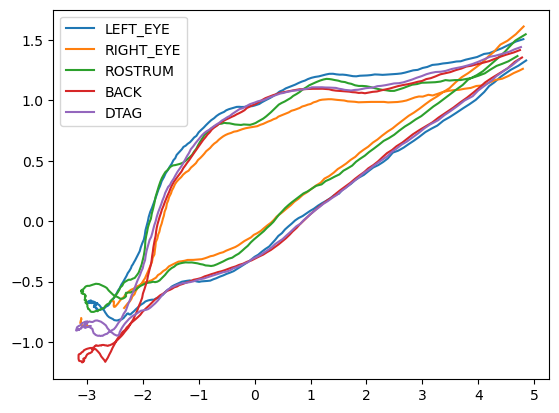

In [22]:
plt.plot(df_xyz_new['LEFT_EYE_X'], df_xyz_new['LEFT_EYE_Y'], label='LEFT_EYE')
plt.plot(df_xyz_new['RIGHT_EYE_X'], df_xyz_new['RIGHT_EYE_Y'], label='RIGHT_EYE')
plt.plot(df_xyz_new['ROSTRUM_X'], df_xyz_new['ROSTRUM_Y'], label='ROSTRUM')
plt.plot(df_xyz_new['BACK_X'], df_xyz_new['BACK_Y'], label='BACK')
plt.plot(df_xyz_new['DTAG_X'], df_xyz_new['DTAG_Y'], label='DTAG')
plt.legend()
plt.show()

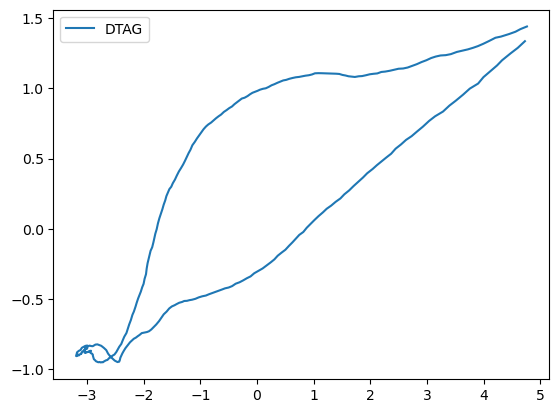

In [23]:
plt.plot(df_xyz_new['DTAG_X'], df_xyz_new['DTAG_Y'], label='DTAG')
plt.legend()
plt.show()

In [24]:
rostrum_to_back = (np.array([df_xyz_new['BACK_X'], df_xyz_new['BACK_Y']]).T
                   - np.array([df_xyz_new['ROSTRUM_X'], df_xyz_new['ROSTRUM_Y']]).T)

In [25]:
rostrum_to_dtag = (np.array([df_xyz_new['BACK_X'], df_xyz_new['BACK_Y']]).T
                   - np.array([df_xyz_new['DTAG_X'], df_xyz_new['DTAG_Y']]).T)

In [26]:
left_to_right = (np.array([df_xyz_new['LEFT_EYE_X'], df_xyz_new['LEFT_EYE_Y']]).T
                   - np.array([df_xyz_new['RIGHT_EYE_X'], df_xyz_new['RIGHT_EYE_Y']]).T)

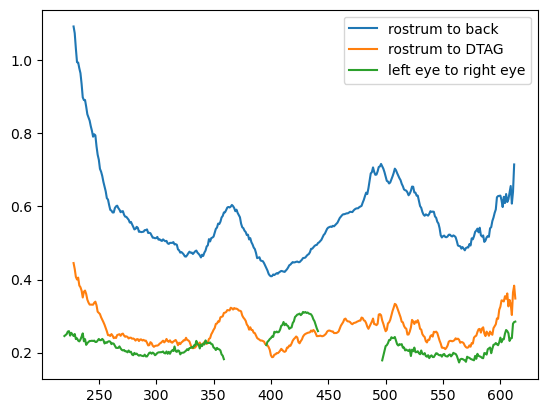

In [27]:
plt.plot(np.linalg.norm(rostrum_to_back, axis=1), label='rostrum to back')
plt.plot(np.linalg.norm(rostrum_to_dtag, axis=1), label='rostrum to DTAG')
plt.plot(np.linalg.norm(left_to_right, axis=1), label='left eye to right eye')
plt.legend()
plt.show()